In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

Data Analysis

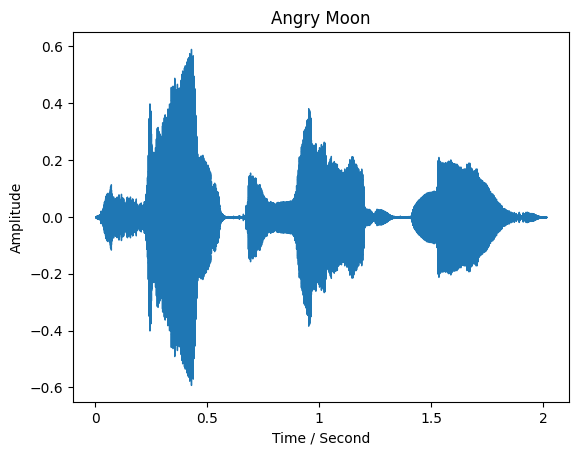

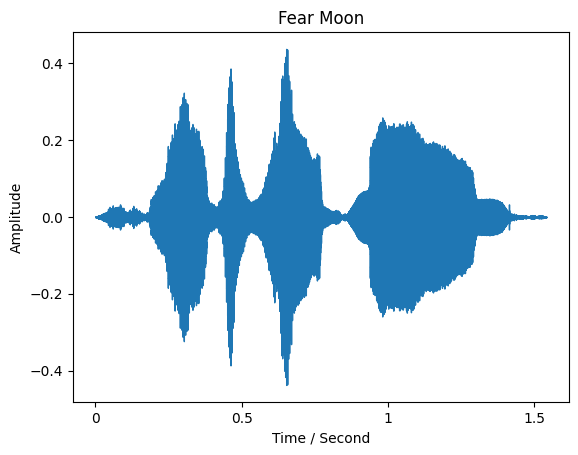

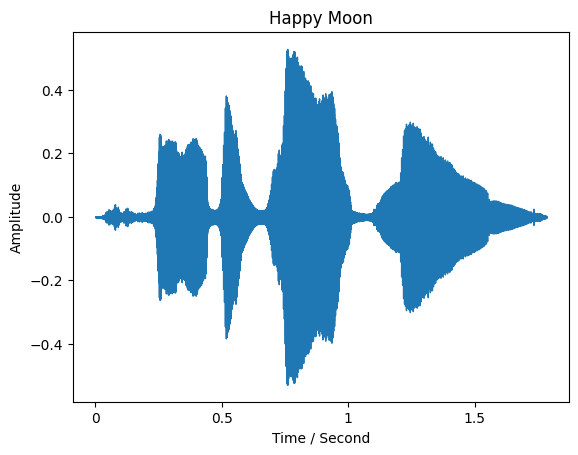

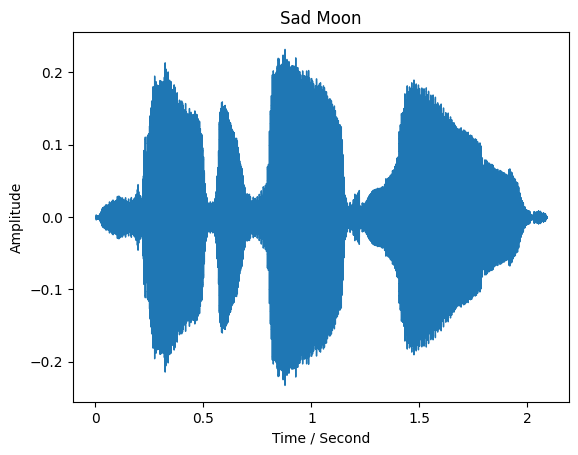

In [5]:
# plot all the moon ones as time and frequency 

signal_angry, sample_rate_angry = librosa.load("./data_folder/angry/YAF_moon_angry.wav")
signal_fear, sample_rate_fear = librosa.load("./data_folder/fear/YAF_moon_fear.wav")
signal_happy, sample_rate_happy = librosa.load("./data_folder/happy/YAF_moon_happy.wav")
signal_sad, sample_rate_sad = librosa.load("./data_folder/sad/YAF_moon_sad.wav")

# angry
plt.figure(1)
librosa.display.waveshow(y=signal_angry, sr=sample_rate_angry)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Angry Moon")
plt.show()
# fear
plt.figure(2)
librosa.display.waveshow(y=signal_fear, sr=sample_rate_fear)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Fear Moon")
plt.show()
# happy
plt.figure(3)
librosa.display.waveshow(y=signal_happy, sr=sample_rate_happy)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Happy Moon")
plt.show()
# sad
plt.figure(4)
librosa.display.waveshow(y=signal_sad, sr=sample_rate_sad)
plt.xlabel('Time / Second')
plt.ylabel('Amplitude')
plt.title("Sad Moon")
plt.show()



In [6]:
# train and test

import os
import random
import shutil

# Set the path to your folders
folder_path = "./data_folder/"

# Set the number of files to select for training
num_train_files = 70

# Loop through each folder
for folder_name in os.listdir(folder_path):
    # Create a list of all the file names in the folder
    file_list = os.listdir(os.path.join(folder_path, folder_name))
    
    # Shuffle the list of file names randomly
    random.shuffle(file_list)
    
    # Split the shuffled list into training and test sets
    train_files = file_list[:num_train_files]
    test_files = file_list[num_train_files:]
    
    # Create new folders for the training and test sets
    train_folder = os.path.join(folder_path, folder_name + "_train")
    test_folder = os.path.join(folder_path, folder_name + "_test")
    
    # Create the new folders
    os.makedirs(train_folder)
    os.makedirs(test_folder)
    
    # Copy the selected training files to the new training folder
    for train_file in train_files:
        src_file = os.path.join(folder_path, folder_name, train_file)
        dst_file = os.path.join(train_folder, train_file)
        shutil.copyfile(src_file, dst_file)
    
    # Copy the selected test files to the new test folder
    for test_file in test_files:
        src_file = os.path.join(folder_path, folder_name, test_file)
        dst_file = os.path.join(test_folder, test_file)
        shutil.copyfile(src_file, dst_file)


Acoustic Feature Extraction

In [ ]:
# loudness
def loudness(loudness_signal):
    df_loudness = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(loudness_signal))
    rms = librosa.feature.rms(S=S)
    df_loudness['Loudness'] = rms[0]
    return df_loudness

# mel-frequency cepstral
def mel_freq(mel_freq_signal, mel_freq_sr):
    df_mfccs = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=mel_freq_signal, sr=mel_freq_sr, n_mfcc=12)
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
    return df_mfccs

# zero crossing
def zero_crossing(zero_crossing_signal):
    df_zero_crossing_rate = pd.DataFrame()
    zcr = librosa.feature.zero_crossing_rate(y=zero_crossing_signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]
    return df_zero_crossing_rate

# chroma
def chroma(chroma_signal, chroma_sr):
    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=chroma_signal, sr=chroma_sr)
    for n_chroma in range(len(chromagram)):
        df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
    return df_chroma

# mel spectrogram
def mel_spectrogram(mel_spect_signal, mel_spect_sr):
    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=mel_spect_signal, sr=mel_spect_sr, n_mels=12)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
    return df_mel_spectrogram